In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import photo_z as pz

%matplotlib inline

# Convert BPZ $p(z)$ file into required format

After running photo-z algorithms on the data challenge, the p(z)'s must be returned as the cumulative distribution function at a set of N<=100 redshift grid points starting at z=0 and going up to the maximum redshift of the simulation. The cut off at the max redshift is to prevent the ML algorithms from artificially learning there are no galaxies beyond this redshift in the simulation.

The will be returned in a FITS file with the following column names:

  * buzzID or galacID: the object ID from the test data file
  * z0 z1 z2 ..... zN-1: the value of the redshift at each of the N grid points

Therefore there will be N+1 columns in total.

Below illustrates converting the output of BPZ into the required format.


In [57]:
probs_lite_file = '../tests/just20gals_pzs.out'

# check the header, in this file's case it is:
# ID  p_bayes(z)  where z=arange(0.0050,2.1100,0.0100) 
redshifts = np.arange(0.0050,2.1100,0.0100)
colNames = ["ID"] + list(redshifts)
pdfs = pd.read_csv(probs_lite_file, skiprows=1, 
                   delimiter=' ', names=colNames, index_col=False)

# column names of the redshift grid
zgrid = pdfs.columns[1:]

pdfs.head()

,ID,0.005,0.015,0.025,0.035,0.045,0.055,0.065,0.075,0.085,...,2.015,2.025,2.035,2.045,2.055,2.065,2.075,2.085,2.095,2.105
0,48,0.006886,0.020070,0.047370,0.090600,0.140500,0.176700,0.180200,0.149000,0.099840,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,43247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000235,0.000294,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,56125,0.000000,0.000138,0.000228,0.000349,0.000502,0.000685,0.000897,0.001133,0.001388,...,0.000548,0.000514,0.000480,0.000448,0.000418,0.000386,0.000351,0.000309,0.000255,0.000192
3,57807,0.000381,0.000706,0.001198,0.001884,0.002775,0.003867,0.005132,0.006527,0.008001,...,0.000339,0.000317,0.000296,0.000277,0.000258,0.000000,0.000000,0.000000,0.000000,0.000000
4,57838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [58]:
# now get the CDFs
cdfs = np.zeros((len(pdfs), len(zgrid)))
for i in range(len(pdfs)):
    
    pofz = pdfs[zgrid].iloc[i]    
    for j in range(len(zgrid)):
        cdfs[i,j] = np.sum(pofz[:j])
    cdfs[i,:] /= sum(pofz)

In [59]:
# now put everything together
ids = np.reshape(pdfs["ID"].values,(len(pdfs),1))
array_to_write = np.hstack((ids, cdfs))
col_names = ["buzzID"] + list(redshifts)

# make the header line from the column names
cn = [str(x) for x in col_names]
cn = " ".join(cn)

# write out to the correctly formatted CDF file
output_cdf_file = 'bpz_cdf_test.txt'
np.savetxt(output_cdf_file, array_to_write, header=cn, comments='')

# Analyse PDFs

In [60]:
# Read in BPZ files

# the CDF file
cdf_df = pz.read_photoz_estimates(output_cdf_file, objid="buzzID", sep=" ")
zgrid = np.asarray(cdf_df.columns).astype(np.float64)
cdf_df.head()

,0.005,0.015,0.025,0.035,0.045,0.055,0.065,0.075,0.085,0.095,...,2.015,2.025,2.035,2.045,2.055,2.065,2.075,2.085,2.095,2.105
buzzID,,,,,,,,,,,,,,,,,,,,,
48,0.0,0.006886,0.026957,0.074328,0.164930,0.305434,0.482139,0.662344,0.811348,0.911191,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
43247,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000235,0.000529,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
56125,0.0,0.000000,0.000138,0.000366,0.000714,0.001216,0.001901,0.002798,0.003931,0.005319,...,0.996098,0.996647,0.997160,0.997641,0.998089,0.998507,0.998893,0.999244,0.999553,0.999808
57807,0.0,0.000381,0.001087,0.002285,0.004169,0.006944,0.010811,0.015943,0.022470,0.030471,...,0.998513,0.998852,0.999169,0.999465,0.999742,1.000000,1.000000,1.000000,1.000000,1.000000
57838,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
# the point_estimates_file 
point_estimates_file = '../tests/just20gals.bpz'
columns = ["buzzID", "Z_B", "Z_B_MIN", "Z_B_MAX", "T_B", "ODDS", 
           "Z_ML", "T_ML", "CHI-SQUARED", "Z_S", "M_0", 
           "OTHER0", "OTHER1", "OTHER2", "OTHER3", "OTHER4"]

point_estimates = pd.read_csv(point_estimates_file, sep="\s+", skiprows=64,
                             names=columns)

# make sure column is integer
point_estimates["buzzID"] = point_estimates["buzzID"].astype('int64')

# set buzzID as index
point_estimates = point_estimates.set_index("buzzID")
point_estimates.head()


,Z_B,Z_B_MIN,Z_B_MAX,T_B,ODDS,Z_ML,T_ML,CHI-SQUARED,Z_S,M_0,OTHER0,OTHER1,OTHER2,OTHER3,OTHER4
buzzID,,,,,,,,,,,,,,,
48,0.065,0.012,0.118,18.000,0.99311,0.065,18.000,7.257,0.064,21.647,48,65191,361977,63.180801,-40.340698
43247,0.655,0.475,0.895,16.000,0.37695,0.635,16.000,0.168,0.739,26.690,43247,7920723,48830,63.490799,-41.498798
56125,0.975,0.365,1.225,3.000,0.18742,1.005,3.000,0.014,0.996,26.423,56125,9275100,371633,63.258499,-42.189899
57807,0.285,0.165,0.635,11.667,0.32745,0.265,11.667,0.870,1.014,26.387,57807,9475573,514847,63.835701,-41.922199
57838,1.015,0.915,1.115,3.333,0.98559,1.005,3.333,0.642,1.027,24.357,57838,9476757,440607,63.867699,-42.179901


In [62]:
# Get Qtheory and Qdata

# Qtheory
ZS = point_estimates["Z_S"]
Qtheory = pz.get_Qtheory(cdf_df, ZS)
pz.add_Q(point_estimates, Qtheory, QT=True)
QTHEORY = point_estimates["QTHEORY"]

# Qdata
Qdata = pz.get_Qdata(cdf_df, QTHEORY)
pz.add_Q(point_estimates, Qdata, QT=False)


In [63]:
# get L2-distance
pz.add_distance(point_estimates)
print "score =", pz.score(point_estimates)

score = 0.653443068408


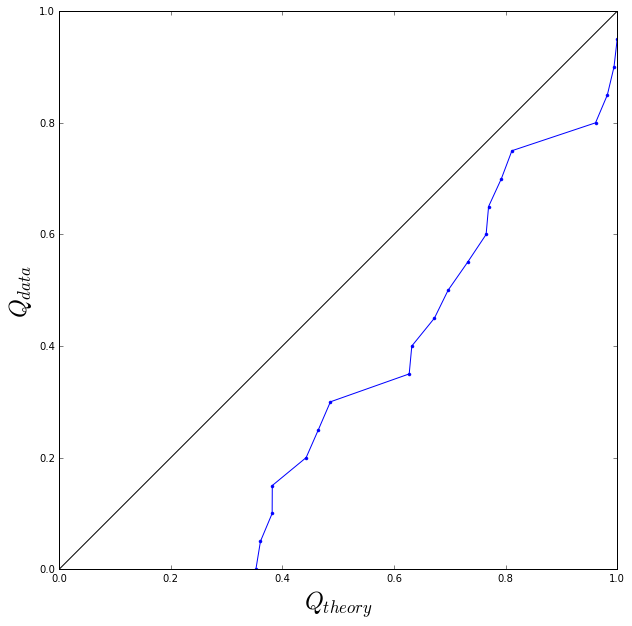

In [64]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(point_estimates.sort_values('QTHEORY')["QTHEORY"], 
        point_estimates.sort_values('QTHEORY')["QDATA"], 
        linestyle='solid', marker='.')
ax.plot([0,1], [0,1], color='black')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('$Q_{theory}$', fontsize=24)
ax.set_ylabel('$Q_{data}$', fontsize=24)